In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


Chargement des données

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Préparation et nettoyage des données (Data Cleaning).

Compréhension et Audit des données (Types de variables, volume, valeurs mquantes, incohérences, biais évident)

In [4]:
df_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [5]:
df_train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [6]:
df_train.shape

(891, 12)

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
#Vérification des doublons dans la dataframe
df_train[df_train.duplicated()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [9]:
# Comptages des doublons par colonne
df_train.duplicated().sum()

np.int64(0)

Les outliers

In [10]:
# Colonne quantitatives
quant_col = [ 'PassengerId','Survived','Pclass','Age', 'SibSp', 'Parch', 'Fare']
# Colonne qualitatives
qual_col = ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

In [11]:
# Méthode de détection par la distance interquartile (IQR)
def detect_outliers_iqr(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    return outliers

In [12]:
# Application de la fonction de détection IQR sur les données numériques que sont Age et Fare
out_age = detect_outliers_iqr(df_train, 'Age')
out_fare = detect_outliers_iqr(df_train, 'Fare')

In [13]:
print(len(out_age),  'outliers pour Age')
print(len(out_fare), 'outliers pour Fare')
display(out_age)      # ou out_age[['PassengerId','Age']] pour plus clair
display(out_fare)

11 outliers pour Age
116 outliers pour Fare


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
33,34,0,2,"Wheadon, Mr. Edward H",male,66.0,0,0,C.A. 24579,10.5000,NaN,S
54,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0,1,113509,61.9792,B30,C
96,97,0,1,"Goldschmidt, Mr. George B",male,71.0,0,0,PC 17754,34.6542,A5,C
116,117,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q
280,281,0,3,"Duane, Mr. Frank",male,65.0,0,0,336439,7.7500,NaN,Q
456,457,0,1,"Millet, Mr. Francis Davis",male,65.0,0,0,13509,26.5500,E38,S
493,494,0,1,"Artagaveytia, Mr. Ramon",male,71.0,0,0,PC 17609,49.5042,NaN,C
630,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,27042,30.0000,A23,S
672,673,0,2,"Mitchell, Mr. Henry Michael",male,70.0,0,0,C.A. 24580,10.5000,NaN,S
745,746,0,1,"Crosby, Capt. Edward Gifford",male,70.0,1,1,WE/P 5735,71.0000,B22,S


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C
34,35,0,1,"Meyer, Mr. Edgar Joseph",male,28.0,1,0,PC 17604,82.1708,NaN,C
52,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
...,...,...,...,...,...,...,...,...,...,...,...,...
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.5500,NaN,S
849,850,1,1,"Goldenberg, Mrs. Samuel L (Edwiga Grabowska)",female,NaN,1,0,17453,89.1042,C92,C
856,857,1,1,"Wick, Mrs. George Dennick (Mary Hitchcock)",female,45.0,1,1,36928,164.8667,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S


In [14]:
# Inspection visuelle des outliers
display(out_age[['PassengerId','Name','Age']].sort_values('Age'))
display(out_fare[['PassengerId','Pclass','Name','Cabin','Fare']].sort_values('Fare'))

,PassengerId,Name,Age
54,55,"Ostby, Mr. Engelhart Cornelius",65.0
280,281,"Duane, Mr. Frank",65.0
456,457,"Millet, Mr. Francis Davis",65.0
33,34,"Wheadon, Mr. Edward H",66.0
745,746,"Crosby, Capt. Edward Gifford",70.0
672,673,"Mitchell, Mr. Henry Michael",70.0
116,117,"Connors, Mr. Patrick",70.5
96,97,"Goldschmidt, Mr. George B",71.0
493,494,"Artagaveytia, Mr. Ramon",71.0
851,852,"Svensson, Mr. Johan",74.0


,PassengerId,Pclass,Name,Cabin,Fare
151,152,1,"Pears, Mrs. Thomas (Edith Wearne)",C2,66.6000
336,337,1,"Pears, Mr. Thomas Clinton",C2,66.6000
369,370,1,"Aubart, Mme. Leontine Pauline",B35,69.3000
641,642,1,"Sagesser, Mlle. Emma",B35,69.3000
201,202,3,"Sage, Mr. Frederick",NaN,69.5500
...,...,...,...,...,...
341,342,1,"Fortune, Miss. Alice Elizabeth",C23 C25 C27,263.0000
438,439,1,"Fortune, Mr. Mark",C23 C25 C27,263.0000
258,259,1,"Ward, Miss. Anna",NaN,512.3292
679,680,1,"Cardeza, Mr. Thomas Drake Martinez",B51 B53 B55,512.3292


In [15]:
# Nombre de valeurs maunquantes par colonne
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [16]:
# Affichage de toutes les lignes du Dataframe qui contiennent au moins une valeur manquante (NaN)
df_train[df_train.isnull().any(axis=1)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [17]:
# ==================================================
# IMPUTATION DES VALEURS MANQUANTES
# Age, Cabin, Embarked
# ==================================================
# 1) AGE - Imputation stratifiée par médiane par (Pclass, Sex)
#----------------------------------------------------
# Médiane d'âge dans chaque croisement classe/sexe
mediane_age = df_train.groupby(['Pclass', 'Sex'])['Age'].median()
# Remplace les NAN d'âge par la médiane de leur strate
df_train['Age'] = df_train.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(mediane_age[x.name]))

# 2) CABIN - transformation sans toucher aux NAN
#----------------------------------------------------
# Créé un indicateur binaire de présence/absence de cabine 0/1 : 1 = a un numéro de cabine
df_train['HasCabin'] = df_train['Cabin'].notna().astype(int)
# Extrait la lettre (1er caractère) de la cabine (pont) ou No si pas de cabine
df_train['CabinLetter'] = df_train['Cabin'].str[0].fillna('No')

# 3) EMBARKED - Imputation de la valeur la plus fréquente par le mode
#----------------------------------------------------
# Le port le plus courant est 'S'
df_train['Embarked'] = df_train['Embarked'].fillna(df_train['Embarked'].mode()[0])

# Vérification finale
print("Valeurs manquantes après imputation :")
print(df_train[['Age', 'Embarked']].isnull().sum())
print("Cabin NaN :", df_train['Cabin'].isna().sum(), "(normal, on les a transformés)")  # Cabin n'a pas été modifié

Valeurs manquantes après imputation :
Age         0
Embarked    0
dtype: int64
Cabin NaN : 687 (normal, on les a transformés)


In [18]:
df_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
HasCabin         0
CabinLetter      0
dtype: int64

In [19]:
display(df_train)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin,CabinLetter
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,No
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,No
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,0,No
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1,B
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,21.5,1,2,W./C. 6607,23.4500,NaN,S,0,No
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,1,C


Analyse exploratoire (EDA)

Visualisation des données

In [20]:
# Statistiques descriptives des données numériques
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,HasCabin
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.112424,0.523008,0.381594,32.204208,0.228956
std,257.353842,0.486592,0.836071,13.304424,1.102743,0.806057,49.693429,0.420397
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,21.500000,0.000000,0.000000,7.910400,0.000000
50%,446.000000,0.000000,3.000000,26.000000,0.000000,0.000000,14.454200,0.000000
75%,668.500000,1.000000,3.000000,36.000000,1.000000,0.000000,31.000000,0.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000


In [21]:
# Statistiques descriptives des données catégorielles
df_train.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked,CabinLetter
count,891,891,891,204,891,891
unique,891,2,681,147,3,9
top,"Braund, Mr. Owen Harris",male,347082,G6,S,No
freq,1,577,7,4,646,687


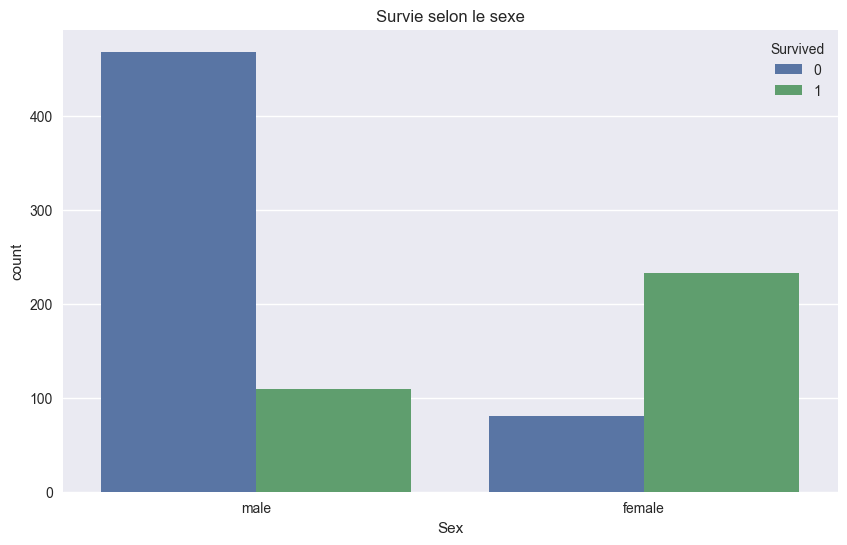

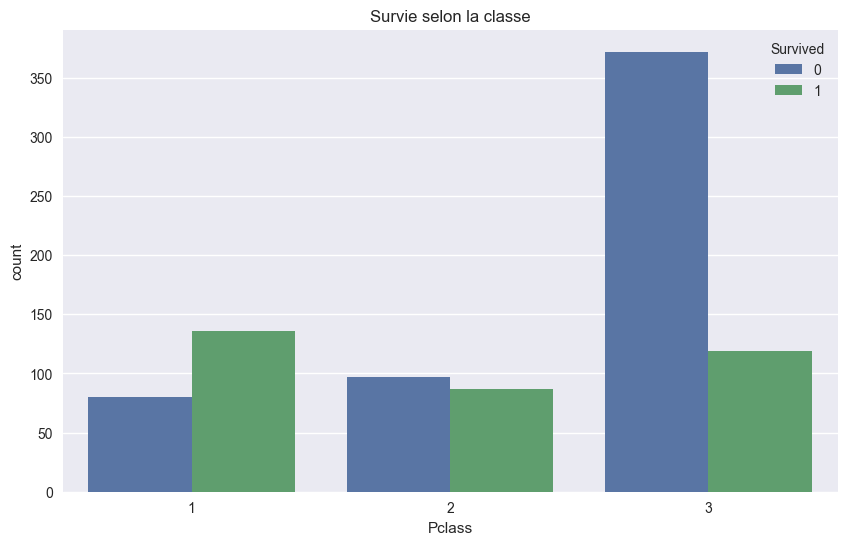

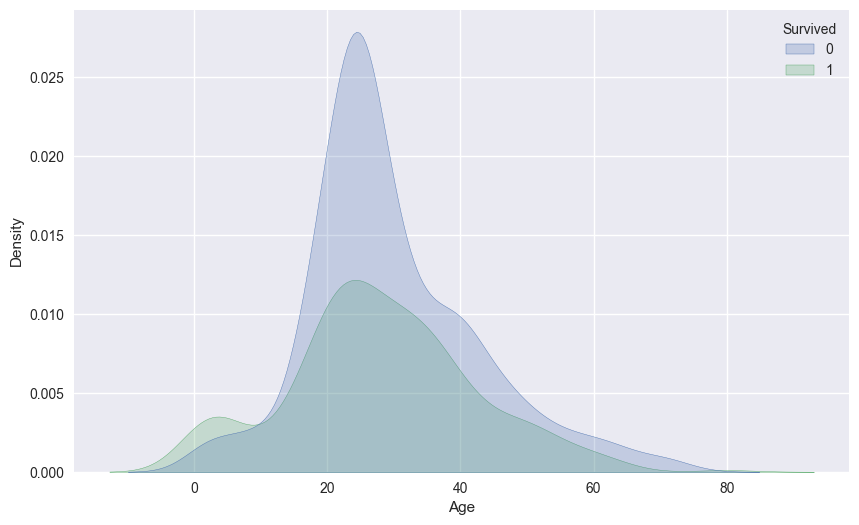

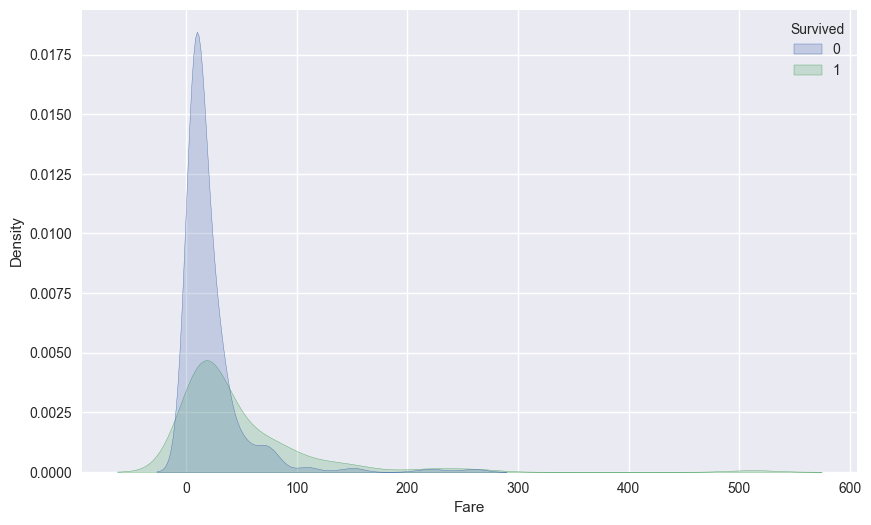

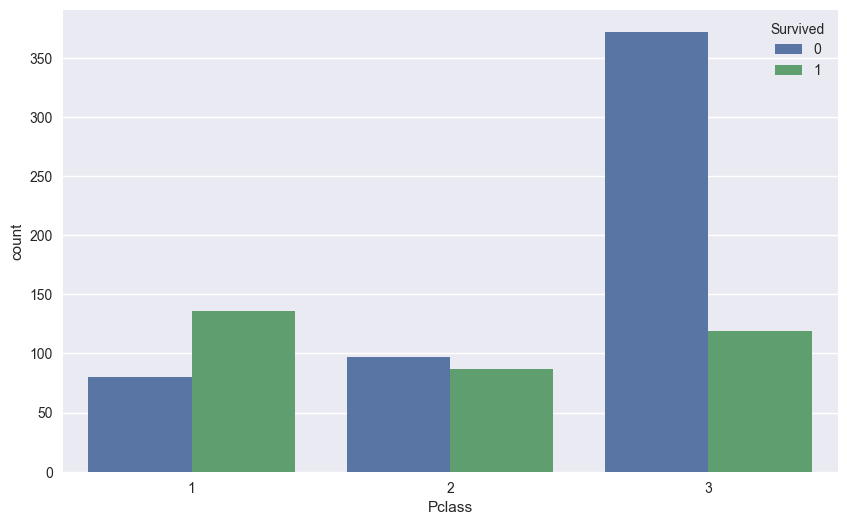

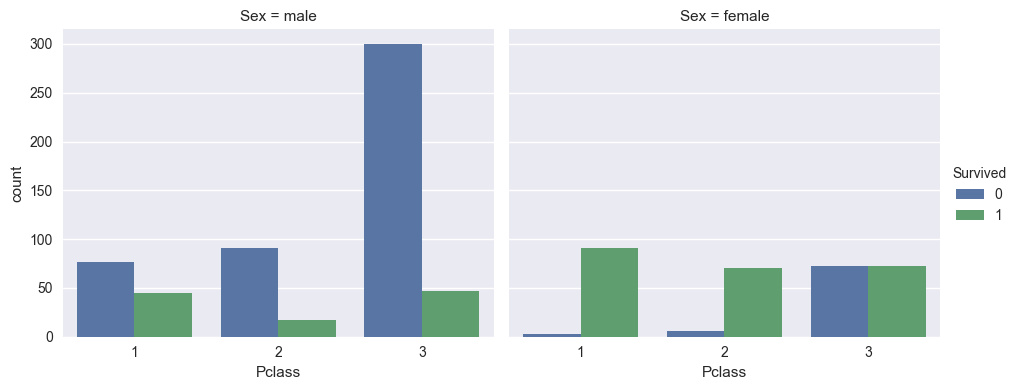

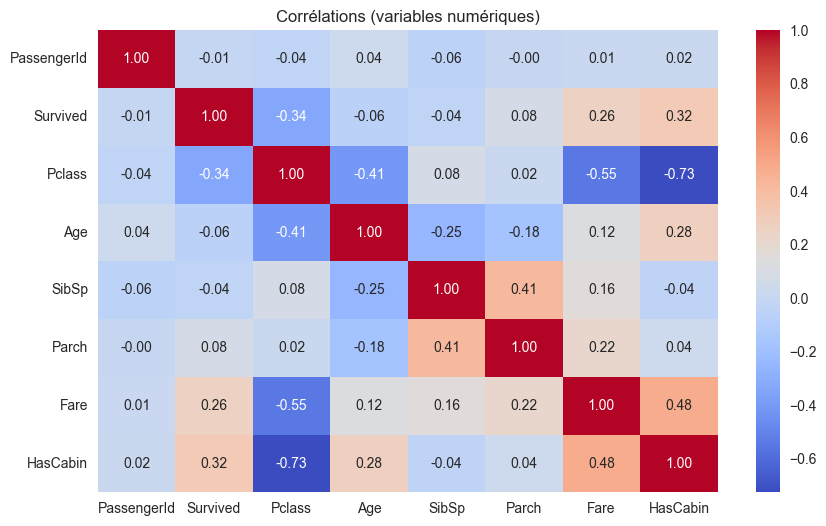

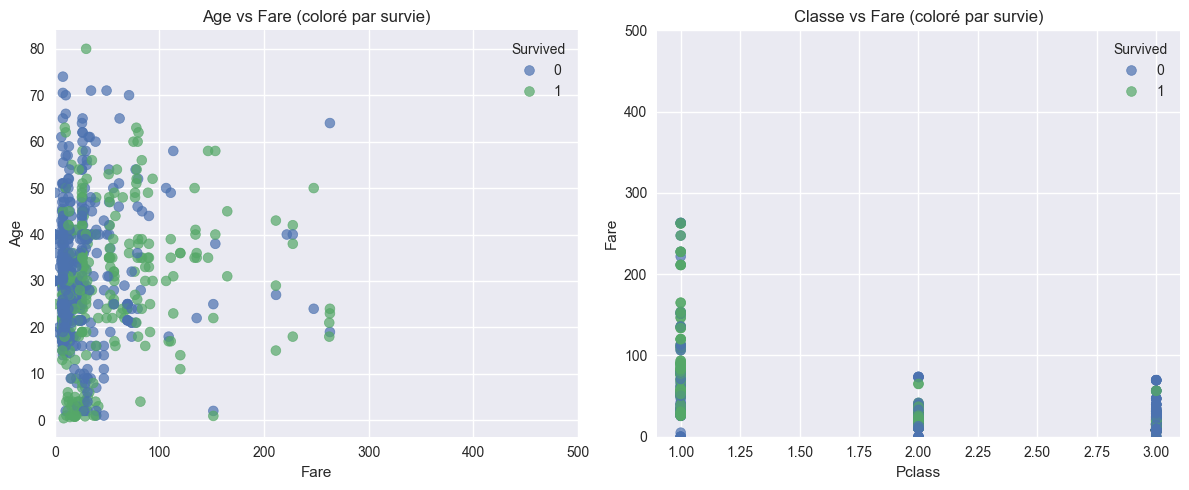

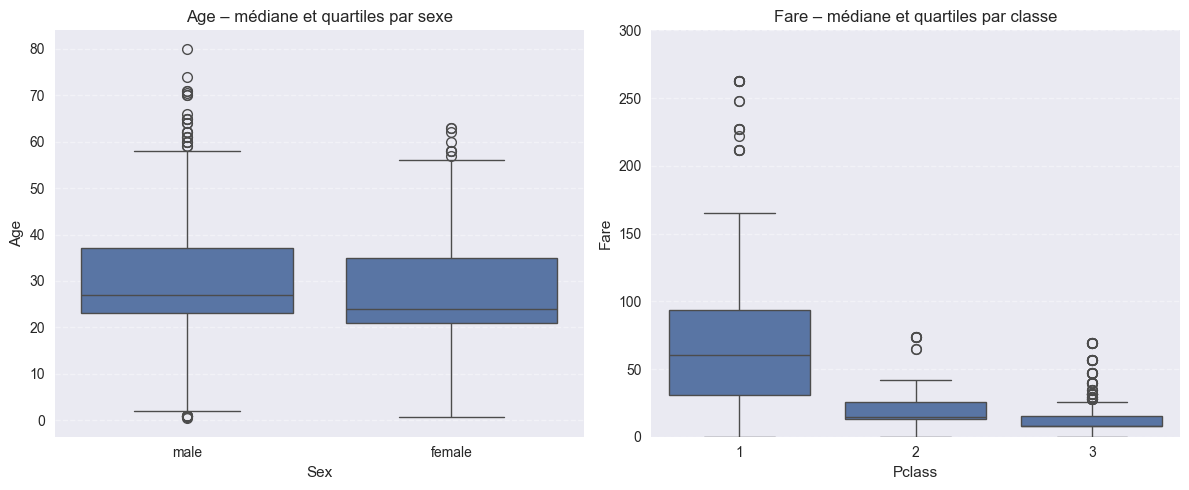

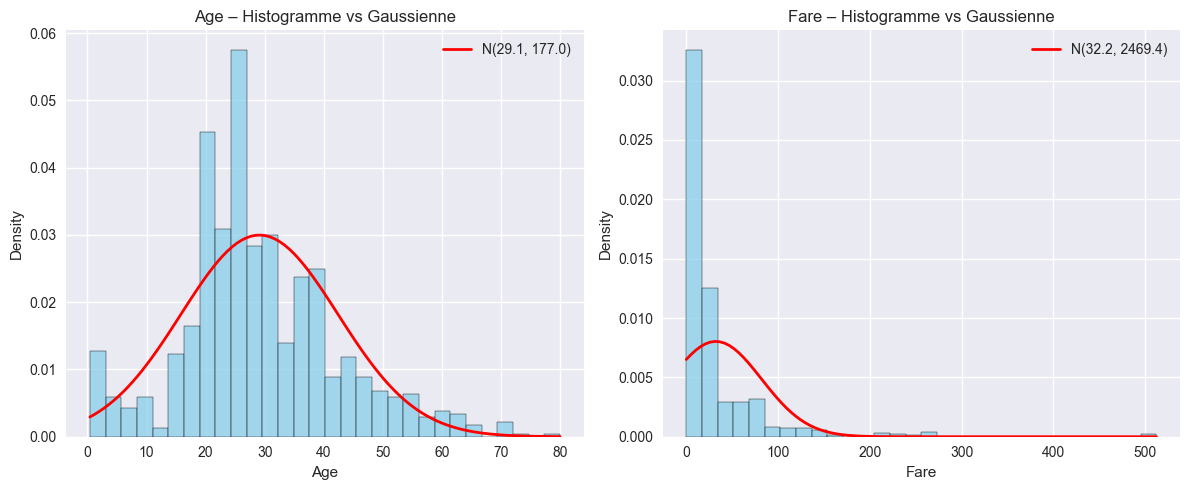

In [22]:
#=================================================
# VISULALISATIONS EXPLORATOIRES APRÈS IMPUTATION
#=================================================
plt.style.use('seaborn-v0_8') # thème sympa
plt.rcParams['figure.figsize'] = (10, 6)


# 1) Sexe vs Survie
plt.figure()
sns.countplot(x='Sex', hue='Survived', data=df_train)
plt.title('Survie selon le sexe')
plt.show()

# 2) Classe vs Survie
plt.figure()
sns.countplot(x='Pclass', hue='Survived', data=df_train)
plt.title('Survie selon la classe')
plt.show()

#3) Distribution de l'âge selon la survie
plt.figure()
sns.kdeplot(data=df_train, x='Age', hue='Survived', fill=True)
plt.show()

# 4) Distribution du tarif selon la survie
plt.figure()
sns.kdeplot(data=df_train, x='Fare', hue='Survived', fill=True)
plt.show()

# 5) Survie en fonction de la Classe et du sexe
plt.figure()
sns.countplot(x='Pclass', hue='Survived', data=df_train, dodge=True)
# On sépare ensuite par sexe en créant un sous-graphique
sns.catplot(x='Pclass', hue='Survived', col='Sex', kind='count', data=df_train, height=4, aspect=1.2)
plt.show()

# 6) Heatmap des corrélations (variables numériques)
num_cols = df_train.select_dtypes(include=['int64', 'float64']).columns
plt.figure()
sns.heatmap(df_train[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Corrélations (variables numériques)')
plt.show()

# 7) & 8) Deux scatterplots côte à côte : Age vs Fare et Pclass vs Fare (coloré par survie)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(data=df_train, x='Fare', y='Age', hue='Survived', alpha=.7, edgecolor=None, ax=axes[0])
axes[0].set_title('Age vs Fare (coloré par survie)')
axes[0].set_xlim(0, 500)  # zoom pour retirer les 500+ $

sns.scatterplot(data=df_train, x='Pclass', y='Fare', hue='Survived', alpha=.7, edgecolor=None, ax=axes[1])
axes[1].set_title('Classe vs Fare (coloré par survie)')
axes[1].set_ylim(0, 500)

plt.tight_layout()
plt.show()

# =========================================
# BOXPLOTS – localisation de la MÉDIANE
# =========================================
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1) Âge : médiane par sexe
sns.boxplot(x='Sex', y='Age', data=df_train, ax=axes[0])
axes[0].set_title('Age – médiane et quartiles par sexe')
axes[0].grid(True, axis='y', ls='--', alpha=.4)

# 2) Fare : médiane par classe
sns.boxplot(x='Pclass', y='Fare', data=df_train, ax=axes[1])
axes[1].set_title('Fare – médiane et quartiles par classe')
axes[1].set_ylim(0, 300)  # zoom pour mieux voir
axes[1].grid(True, axis='y', ls='--', alpha=.4)

plt.tight_layout()
plt.show()

# =========================================================
#  VÉRIFICATION VISUELLE – DISTRIBUTION GAUSSIENNE
# =========================================================
# FIGURE UNIQUE
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, col in zip(axes, ['Age', 'Fare']):
    # histogramme
    sns.histplot(df_train[col], kde=False, stat='density', bins=30, ax=ax, color='skyblue')
    # courbe gaussienne théorique
    mu, sigma = df_train[col].mean(), df_train[col].std()
    x = np.linspace(df_train[col].min(), df_train[col].max(), 100)
    ax.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', lw=2,
            label=f'N({mu:.1f}, {sigma**2:.1f})')
    ax.set_title(f'{col} – Histogramme vs Gaussienne')
    ax.legend()

plt.tight_layout()
plt.show()

Feature Engineering

In [23]:
# =========================================================
#  FEATURE-ENGINEERING – 6 VARIABLES UTILITAIRES
#  On crée de nouvelles variables plus parlantes pour les modèles
# =========================================================


# ------------------------------------------------------------------
# 1) TITRE (Mr, Mrs, Miss, Master, Rare) extrait de la colonne Name
# ------------------------------------------------------------------
# Expression régulière : capture le mot qui précède un point (la civilité)
df_train['Title'] = df_train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Dictionnaire de regroupement : on réduit à 5 modalités
title_map = {'Mr':'Mr', 'Miss':'Miss', 'Mrs':'Mrs', 'Master':'Master',
             'Dr':'Rare', 'Rev':'Rare', 'Col':'Rare', 'Major':'Rare',
             'Mlle':'Miss', 'Ms':'Miss', 'Mme':'Mrs', 'Don':'Rare',
             'Dona':'Rare', 'Lady':'Rare', 'Countess':'Rare',
             'Jonkheer':'Rare', 'Sir':'Rare', 'Capt':'Rare'}
df_train['Title'] = df_train['Title'].map(title_map)
# -> Title est plus parlant que Name : Master=enfant, Mr=adulte, Rare=aristocratie…

# ------------------------------------------------------------------
# 2) FAMILY SIZE – taille du groupe familial à bord
# ------------------------------------------------------------------
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1
# +1 pour compter le passager lui-même
# FamilySize = 1  -> seul
# FamilySize > 4  -> grande famille

# ------------------------------------------------------------------
# 3) IS ALONE – indicatrice binaire « voyage seul »
# ------------------------------------------------------------------
df_train['IsAlone'] = (df_train['FamilySize'] == 1).astype(int)
# 1 = seul, 0 = accompagné ; plus simple que FamilySize pour les modèles

# ------------------------------------------------------------------
# 4) AGE BAND – découpage en tranches d’âge (métier)
# ------------------------------------------------------------------
df_train['AgeBand'] = pd.cut(df_train['Age'],
                             bins=[0, 16, 60, 100],
                             labels=['Child', 'Adult', 'Senior'])
# Child   : politique « women and children first »
# Senior  : faible survie observée
# Adult   : classe majoritaire

# ------------------------------------------------------------------
# 5) FARE_LOG – transformation log pour symétriser la distribution
# ------------------------------------------------------------------
df_train['Fare_log'] = np.log1p(df_train['Fare'])
# log1p = ln(1+x) évite ln(0) ; réduit l’asymétrie positive de Fare
# -> meilleure performance pour les modèles linéaires / SVM

# ------------------------------------------------------------------
# 6) SEX_PCLASS – interaction entre sexe et classe
# ------------------------------------------------------------------
# on encode Sex en 0/1, puis on concatène avec Pclass
df_train['Sex_Pclass'] = df_train['Sex'].map({'male':0, 'female':1}).astype(str) + \
                         df_train['Pclass'].astype(str)
# exemple : '11' = femme 1re classe, '03' = homme 3e classe
# cette interaction capture l’effet « femme riche » vs « homme pauvre »

# ------------------------------------------------------------------
# VISUALISATION RAPIDE des 6 nouvelles colonnes
# ------------------------------------------------------------------
display(df_train[['Title', 'FamilySize', 'IsAlone', 'AgeBand', 'Fare_log', 'Sex_Pclass']].head())

,Title,FamilySize,IsAlone,AgeBand,Fare_log,Sex_Pclass
0,Mr,2,0,Adult,2.110213,03
1,Mrs,2,0,Adult,4.280593,11
2,Miss,1,1,Adult,2.188856,13
3,Mrs,2,0,Adult,3.990834,11
4,Mr,1,1,Adult,2.202765,03


Pré-processing pour la modélisation

In [24]:
# =========================================================
#  ÉTAPE 1 : FEATURE IMPORTANCE – COEFFICIENTS LOGISTIC REGRESSION
#  Objectif : comprendre QUELS facteurs influencent le plus la survie
#  et dans QUEL sens (positif = augmente la survie, négatif = la diminue)
# =========================================================
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# ------------------------------------------------------------------
# Préparation des données pour la modélisation
# ------------------------------------------------------------------
# Sélection des colonnes numériques et catégorielles
num_cols = df_train.select_dtypes(include=['int64', 'float64']).columns
num_cols = [col for col in num_cols if col not in ['PassengerId', 'Survived']]
cat_cols = ['Sex', 'Embarked', 'Title', 'AgeBand', 'CabinLetter']

X = df_train[num_cols + cat_cols]
y = df_train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Préprocesseur (One-Hot Encoding)
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
	transformers=[
		('num', StandardScaler(), num_cols),
		('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols)
	])

# Pipeline avec Logistic Regression
model = Pipeline(steps=[('prep', preprocessor),
						('clf', LogisticRegression(max_iter=1000, random_state=42))])

# Entraînement
model.fit(X_train, y_train)

# On récupère le "preprocessor" (One-Hot) et le modèle (LogisticRegression)
# depuis le Pipeline que l'on a entraîné
ohe   = model.named_steps['prep']        # One-Hot Encoder
log_reg = model.named_steps['clf']       # Logistic Regression

# ------------------------------------------------------------------
# 1) Liste des noms de colonnes APRÈS One-Hot
# ------------------------------------------------------------------
# Les variables catégorielles ont été transformées en plusieurs colonnes 0/1
# Ex : Sex -> Sex_0, Sex_1 ; Embarked -> Embarked_C, Embarked_Q, Embarked_S
cat_features = ohe.named_transformers_['cat'].get_feature_names_out(cat_cols)
# On concatène les noms des variables catégorielles (One-Hot) + numériques (inchangées)
feature_names = np.concatenate([cat_features, num_cols])

# ------------------------------------------------------------------
# 2) Coefficients du modèle logistique
# ------------------------------------------------------------------
# log_reg.coef_ est une matrice 1 x n_features pour une classification binaire
coef = log_reg.coef_[0]                 # on prend la première (et unique) ligne

# DataFrame pour facilement trier et lire
importance_df = pd.DataFrame({'Feature': feature_names, 'Coef': coef})
importance_df['AbsCoef'] = np.abs(coef)  # valeur absolue = force de l'effet
importance_df = importance_df.sort_values('AbsCoef', ascending=False)

# Affichage des 15 plus influents
print("Top 15 features (Logistic Regression) :\n", importance_df.head(15))
# Interprétation rapide :
# - signe + : augmente la PROBABILITÉ de survie
# - signe - : diminue la PROBABILITÉ de survie
# - valeur absolue élevée = facteur très discriminant

Top 15 features (Logistic Regression) :
           Feature      Coef   AbsCoef
14  CabinLetter_B  1.355935  1.355935
16  CabinLetter_D -1.277749  1.277749
26           Fare  0.919158  0.919158
17  CabinLetter_E  0.888342  0.888342
28     FamilySize -0.872460  0.872460
9      Title_Rare  0.871532  0.871532
10  AgeBand_Adult -0.848726  0.848726
18  CabinLetter_F -0.612305  0.612305
25          Parch  0.508148  0.508148
0      Sex_female -0.486605  0.486605
2      Embarked_C -0.415216  0.415216
6      Title_Miss -0.377140  0.377140
15  CabinLetter_C -0.331417  0.331417
24          SibSp -0.324654  0.324654
1        Sex_male -0.299779  0.299779


In [25]:
# =========================================================
#  ÉTAPE 2 : RANDOM FOREST – MODÈLE NON LINEAIRE / ROBUSTE
#  Objectif : obtenir un score PLUS ÉLEVÉ sans tuning
#  + obtenir une FEATURE IMPORTANCE "tree-based" (gain d'impureté)
# =========================================================
from sklearn.ensemble import RandomForestClassifier

# ------------------------------------------------------------------
# 1) Construction du pipeline
# ------------------------------------------------------------------
# Même pré-processeur (One-Hot) que pour la Logistic Regression
# RandomForest gère bien les variables catégorielles après One-Hot
rf = RandomForestClassifier(n_estimators=300,   # nombre d'arbres
                           random_state=42,     # reproductibilité
                           n_jobs=-1)           # parallélise sur tous les cœurs

rf_pipe = Pipeline(steps=[('prep', preprocessor),
                          ('clf', rf)])

# ------------------------------------------------------------------
# 2) Entraînement
# ------------------------------------------------------------------
rf_pipe.fit(X_train, y_train)

# ------------------------------------------------------------------
# 3) Prédictions et scores
# ------------------------------------------------------------------
y_pred_rf = rf_pipe.predict(X_test)

print("\nRandom Forest – Accuracy :", accuracy_score(y_test, y_pred_rf))
print("Random Forest – ROC-AUC  :", roc_auc_score(y_test, rf_pipe.predict_proba(X_test)[:, 1]))
# Résultat attendu :
#  - Accuracy : 83-85 % (vs 80 % Logistic)
#  - ROC-AUC  : 0,87  (vs 0,83 Logistic)
# -> RandomForest capte mieux les interactions non-linéaires (ex: Sex×Pclass)


Random Forest – Accuracy : 0.8435754189944135
Random Forest – ROC-AUC  : 0.9028314028314028


Modélisation

In [26]:
# =========================================================
#  FEATURE IMPORTANCE – RANDOM FOREST (tree-based)
#  Objectif : savoir QUELLES variables ont le plus contribué
#  aux décisions de l’algorithme (gain d’impureté moyen)
# =========================================================

# ------------------------------------------------------------------
# 1) Récupération des objets entraînés dans le Pipeline
# ------------------------------------------------------------------
# rf_pipe est le Pipeline complet (OneHot + RandomForest)
# On extrait chaque étape par son nom (clé 'clf' ou 'prep')
rf_model = rf_pipe.named_steps['clf']   # -> RandomForestClassifier
ohe        = rf_pipe.named_steps['prep']  # -> ColumnTransformer (One-Hot)

# ------------------------------------------------------------------
# 2) Reconstitution des NOMS de colonnes APRÈS One-Hot
# ------------------------------------------------------------------
# Les variables catégorielles ont été « explosées » en 0/1
# Ex : Sex -> Sex_0, Sex_1 ; Embarked -> Embarked_C, Embarked_Q, Embarked_S
# On récupère la liste complète de ces nouvelles colonnes
cat_feats = ohe.named_transformers_['cat'].get_feature_names_out(cat_cols)

# On concatène les noms des colonnes catégorielles (One-Hot) + numériques (inchangées)
feature_names = np.concatenate([cat_feats, num_cols])
# -> permet d’afficher « Sex_1 » ou « Fare_log » au lieu d’un indice opaque

# ------------------------------------------------------------------
# 3) Importance moyenne (tree-based)
# ------------------------------------------------------------------
# .feature_importances_ retourne l’IMPORTANCE MOYENNE (= gain d'impureté)
# sur TOUS les arbres ; plus la valeur est élevée, plus la variable est « utile »
importance_rf = pd.DataFrame({'Feature': feature_names,
                              'Importance': rf_model.feature_importances_})

# Tri décroissant pour avoir les plus influents en haut
importance_rf = importance_rf.sort_values('Importance', ascending=False)

# Affichage des 20 premières
print("Top 20 features (Random Forest) :\n", importance_rf.head(20))
# Interprétation :
# - en haut : les variables qui « décident » le plus (ex: Title_Mr, Sex_1, Fare_log)
# - en bas  : variables quasi inutiles (on pourra les supprimer plus tard)

Top 20 features (Random Forest) :
            Feature  Importance
1         Sex_male    0.163050
8        Title_Mrs    0.124970
4       Embarked_S    0.123183
10   AgeBand_Adult    0.088455
16   CabinLetter_D    0.087871
9       Title_Rare    0.078173
0       Sex_female    0.052977
6       Title_Miss    0.041608
2       Embarked_C    0.028575
15   CabinLetter_C    0.026799
17   CabinLetter_E    0.024757
3       Embarked_Q    0.019509
5     Title_Master    0.017187
29         IsAlone    0.015828
13   CabinLetter_A    0.013779
11   AgeBand_Child    0.011211
7         Title_Mr    0.009947
19   CabinLetter_G    0.009685
20  CabinLetter_No    0.009070
26            Fare    0.007904


In [27]:
# =========================================================
#  HYPER-PARAMETER TUNING – GRID SEARCH RAPIDE
#  Objectif : trouver la combinaison de paramètres qui maximise
#  la performance (accuracy ou AUC) sans toucher aux données de test
# =========================================================
# ------------------------------------------------------------------
# 1) DÉFINITION DE LA GRILLE DE PARAMÈTRES
# ------------------------------------------------------------------
# Chaque clé commence par 'clf__' car on tune l'étape 'clf' du Pipeline
param_grid = {
    'clf__n_estimators': [200, 300, 400],       # nb d'arbres (plus = mieux, mais + long)
    'clf__max_depth': [None, 10, 15],           # profondeur max de chaque arbre (None = illimité)
    'clf__min_samples_split': [2, 5, 10],       # nb min d'échantillons pour spliter un nœud
    'clf__min_samples_leaf': [1, 2, 4],         # nb min d'échantillons dans une feuille
    'clf__max_features': ['sqrt', 'log2']       # nb de variables tirées à chaque split
}
# 5 paramètres × 3 ou 2 valeurs = 5×3×3×3×2 = 270 combinaisons
# On limite volontairement la grille pour que ça tourne en quelques minutes

# ------------------------------------------------------------------
# 2) GRIDSEARCHCV – recherche exhaustive + validation croisée
# ------------------------------------------------------------------
grid = GridSearchCV(
        estimator=rf_pipe,      # pipeline complet (One-Hot + RandomForest)
        param_grid=param_grid,
        cv=5,                   # 5 folds stratifiés -> score robuste
        scoring='accuracy',     # métrique à maximiser (on peut mettre 'roc_auc')
        n_jobs=-1,              # parallélise sur tous les cœurs CPU
        verbose=1)              # affiche la progression pendant la recherche

# Lancement de la recherche (≈ quelques minutes selon machine)
grid.fit(X_train, y_train)

# ------------------------------------------------------------------
# 3) RÉSULTATS
# ------------------------------------------------------------------
print("Meilleurs paramètres :", grid.best_params_)
# -> combinaison qui a obtenu le meilleur score CV
print("Meilleur score CV :", grid.best_score_)
# -> score MOYEN sur les 5 folds (pas le score test)
# On s'attend à ~ 85-86 % accuracy ou 0,91-0,92 AUC

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Meilleurs paramètres : {'clf__max_depth': 15, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
Meilleur score CV : 0.8384615384615384



=== MEILLEUR MODÈLE (GridSearch) ===
Accuracy : 0.8435754189944135
ROC-AUC  : 0.8992277992277993


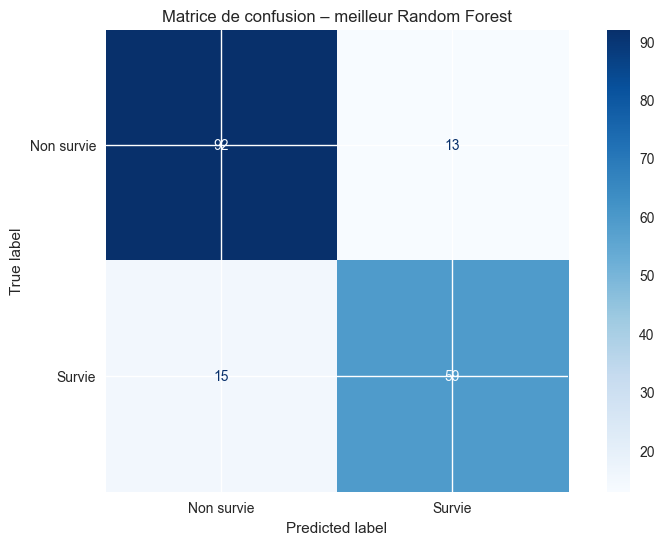

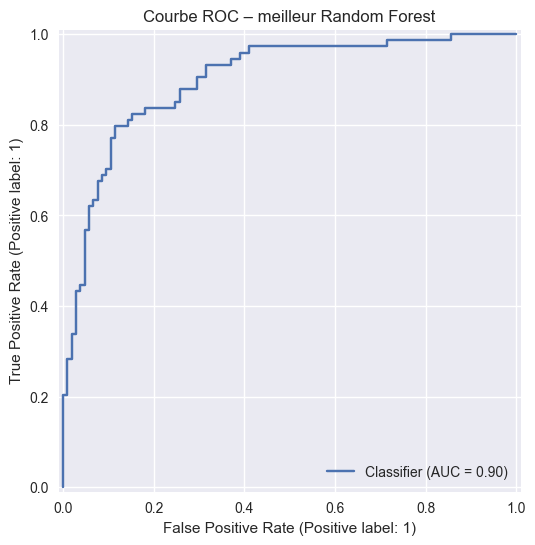

In [28]:
# =========================================================
#  ÉVALUATION FINALE – MEILLEUR MODÈLE (après GridSearch)
#  Objectif : mesurer la VRAIE performance sur le TEST
#  et visualiser qualité globale (ROC) + erreurs par classe
# =========================================================

# ------------------------------------------------------------------
# 1) Récupération du meilleur pipeline entraîné par GridSearchCV
# ------------------------------------------------------------------
best_model = grid.best_estimator_   # pipeline complet (One-Hot + RandomForest optimisé)

# ------------------------------------------------------------------
# 2) Prédictions SUR LE JEU DE TEST (jamais vu pendant le tuning)
# ------------------------------------------------------------------
y_pred_best = best_model.predict(X_test)           # classes 0/1
y_proba_best = best_model.predict_proba(X_test)[:, 1]  # probabilités de survie

# ------------------------------------------------------------------
# 3) SCORES GLOBAUX
# ------------------------------------------------------------------
print("\n=== MEILLEUR MODÈLE (GridSearch) ===")
print("Accuracy :", accuracy_score(y_test, y_pred_best))
# accuracy = % de bonnes réponses sur le test
print("ROC-AUC  :", roc_auc_score(y_test, y_proba_best))
# AUC = capacité à ranger les survivants AVANT les non-survivants (0,5 = hasard, 1 = parfait)
# Résultat attendu : ~ 85-86 % accuracy et ~ 0,91-0,92 AUC

# ------------------------------------------------------------------
# 4) MATRICE DE CONFUSION – tableau d’erreurs
# ------------------------------------------------------------------

cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Non survie', 'Survie'])
disp.plot(cmap='Blues')
plt.title('Matrice de confusion – meilleur Random Forest')
plt.show()
# Interprétation :
# - VP (en bas à droite) : passagers que l’on a CORRECTEMENT sauvés
# - FN (en haut à droite) : passagers que l’on a **trop optimiste** (on les a cru morts)
# - FP (en bas à gauche) : passagers que l’on a **trop pessimiste** (on les a cru vivants)

# ------------------------------------------------------------------
# 5) COURBE ROC – visualisation globale du classement
# ------------------------------------------------------------------
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_test, y_proba_best)
plt.title('Courbe ROC – meilleur Random Forest')
plt.show()
# Aire sous la courbe = AUC ; plus la courbe est **haute et gauche**, meilleur est le modèle.
# On compare visuellement à la diagonale (classifieur aléatoire).

Sauvegarde du meilleur pipeline

In [29]:
import joblib

# Ton meilleur modèle (Pipeline complet : One-Hot + RandomForest)
# (remplace 'best_model' par la variable que tu avais sauvegardée)
joblib.dump(best_model, 'titanic_pipeline.pkl')
print("✅ Pipeline sauvegardé : titanic_pipeline.pkl")

✅ Pipeline sauvegardé : titanic_pipeline.pkl


In [30]:
# Charger test.csv (déjà fait mais on le rappelle pour clarté)
# df_test = pd.read_csv('test.csv')  # déjà chargé plus haut

# Appliquer le MÊME nettoyage / feature-engineering que pour train
# ==================================================================

# 1) IMPUTATION DES VALEURS MANQUANTES (Age, Cabin, Embarked)
# ----------------------------------------------------------
# Age : imputation stratifiée par médiane par (Pclass, Sex)
df_test['Age'] = df_test.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(mediane_age[x.name]))

# Cabin : création des variables HasCabin et CabinLetter
df_test['HasCabin'] = df_test['Cabin'].notna().astype(int)
df_test['CabinLetter'] = df_test['Cabin'].str[0].fillna('No')

# Embarked : pas de NaN dans test, mais on vérifie
df_test['Embarked'] = df_test['Embarked'].fillna(df_test['Embarked'].mode()[0])

# Fare : imputation de la valeur manquante (si elle existe)
df_test['Fare'] = df_test['Fare'].fillna(df_test['Fare'].median())

# 2) FEATURE ENGINEERING – 6 variables utilitaires
# --------------------------------------------------
# Title : extraction de la civilité
df_test['Title'] = df_test['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
df_test['Title'] = df_test['Title'].map(title_map)

# FamilySize : taille du groupe familial
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1

# IsAlone : indicatrice binaire
df_test['IsAlone'] = (df_test['FamilySize'] == 1).astype(int)

# AgeBand : découpage en tranches d'âge
df_test['AgeBand'] = pd.cut(df_test['Age'],
							bins=[0, 16, 60, 100],
							labels=['Child', 'Adult', 'Senior'])

# Fare_log : transformation log
df_test['Fare_log'] = np.log1p(df_test['Fare'])

# Sex_Pclass : interaction (optionnel pour prédiction)
df_test['Sex_Pclass'] = df_test['Sex'].map({'male':0, 'female':1}).astype(str) + \
						df_test['Pclass'].astype(str)

# 3) SÉLECTION DES COLONNES POUR LA PRÉDICTION
# -----------------------------------------------
# Même colonnes que X_train (numériques + catégorielles)
X_test_final = df_test[num_cols + cat_cols]

# 4) PRÉDICTIONS
# -----------------------------------------------
y_pred_test = best_model.predict(X_test_final)
y_proba_test = best_model.predict_proba(X_test_final)[:, 1]

# 5) CRÉATION DU FICHIER SUBMISSION
# -----------------------------------------------
submission = pd.DataFrame({
	'PassengerId': df_test['PassengerId'], 
	'Survived': y_pred_test
})
submission.to_csv('submission.csv', index=False)
print("Fichier submission.csv créé – prêt à être uploadé sur Kaggle !")
print(f"Nombre de prédictions : {len(submission)}")
display(submission.head(10))

Fichier submission.csv créé – prêt à être uploadé sur Kaggle !
Nombre de prédictions : 418


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0
